# CNN 기반 강아지 고양이 이미지 분류

## dogs-vs-cats 다운로드

In [ ]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

Downloading...
From: https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:04<00:00, 197MB/s]


'dogs-vs-cats.zip'

**압축 풀기**

In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

**기존 Train 폴더 (고양이,강아지 사진이 들어있다.)**

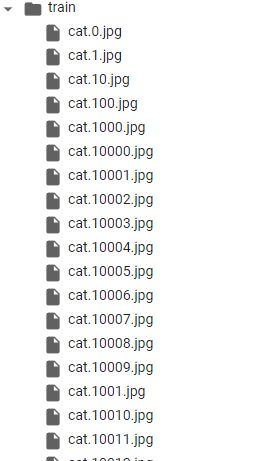

## Directory 배분

In [ ]:
import os, shutil, pathlib

# 기존 dir
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# Directory 배분 함수
def make_subset(sub_dir, start_index, end_index):

    # 고양이, 강아지
    for category in ("cat", "dog"):

        # 새로운 Directory 이름
        dir = new_base_dir / sub_dir / category
        os.makedirs(dir)

        # 파일 가져오기
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        # shutil.copyfile() 함수는 원본 파일을 대상 경로로 복사
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname,
                            dst = dir / fname)


make_subset(sub_dir= "train", start_index=0, end_index=1000)
make_subset(sub_dir= "validation", start_index=1000, end_index=1500)
make_subset(sub_dir= "test", start_index=1500, end_index=2500)

**각 Train,Vaild,Test 폴더 분리 후 강아지,고양이 사진 분리**

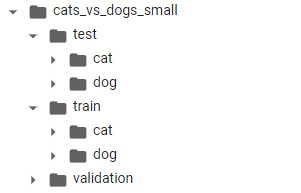

## Directory 이미지 불러오기

**image_dataset_from_directory()를 사용하여 Labeling 및 이미지 불러오기**

1. 이미지 Tensor로 변환

2. 각 폴더 별 다른 Label 부여

2. (이미지 Tensor, Label) 형태로 불러오기

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

# 이미지 Tensor로 변환
# 각 폴더별 다른 Label 부여 (/dogs, /cats 각 Label 부여)
# (이미지 Tensor, Label) 형태 Load
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**저장된 이미지 Shape 확인**

Target: tf.Tensor(0, shape=(), dtype=int32)


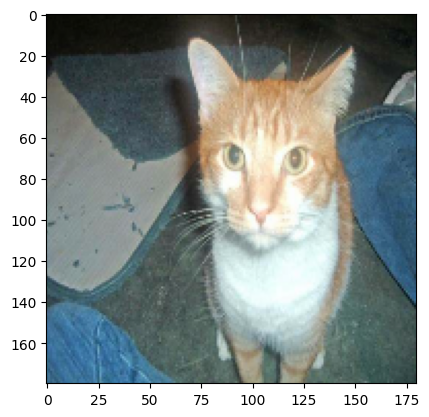

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img


for data_batch, labels_batch in train_dataset:
    plt.imshow(array_to_img(data_batch[0]))
    print("Target:", labels_batch[0])   # 고양이 = 0, 강아지 = 1
    break

## CNN 모델 생성

In [ ]:
import keras
from keras import layers

# 데이터 증식
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Conv 입력 차원 4차원 = (None,180,180, 3)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)         # 데이터 증식
x = layers.Rescaling(1./255)(x)       # 데이터 정규화 (Floating Points)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

# Classifier
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# CNN 모델 생성
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

## 모델 학습

**Checkpoint과 EarlyStopping 기법 활용**

In [ ]:
callbacks = [

    # Check Point -> 최고 성능 모델 저장
    keras.callbacks.ModelCheckpoint(
        filepath="dogs_vs_cats.keras",
        save_best_only=True,
        monitor="val_loss"),

     # Early Stopping -> 조기 종료
     keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 15
    )
]

In [ ]:
model.compile(loss="binary_crossentropy",   # 2진 분류
              optimizer="rmsprop",
              metrics=["accuracy"])

# 학습
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)    # Callback

Epoch 1/100
63/63 [==============================] - 8s 83ms/step - loss: 0.3426 - accuracy: 0.8610 - val_loss: 0.4752 - val_accuracy: 0.8240
Epoch 2/100
63/63 [==============================] - 5s 68ms/step - loss: 0.2846 - accuracy: 0.8850 - val_loss: 0.4524 - val_accuracy: 0.8090
Epoch 3/100
63/63 [==============================] - 6s 83ms/step - loss: 0.2772 - accuracy: 0.8895 - val_loss: 0.4608 - val_accuracy: 0.8350
Epoch 4/100
63/63 [==============================] - 5s 68ms/step - loss: 0.2860 - accuracy: 0.8780 - val_loss: 0.5351 - val_accuracy: 0.8220
Epoch 5/100
63/63 [==============================] - 5s 68ms/step - loss: 0.2827 - accuracy: 0.8830 - val_loss: 0.4253 - val_accuracy: 0.8370
Epoch 6/100
63/63 [==============================] - 6s 84ms/step - loss: 0.2663 - accuracy: 0.8890 - val_loss: 0.4221 - val_accuracy: 0.8220
Epoch 7/100
63/63 [==============================] - 4s 66ms/step - loss: 0.2469 - accuracy: 0.8930 - val_loss: 0.4802 - val_accuracy: 0.8230
Epoch 

**학습 그래프**

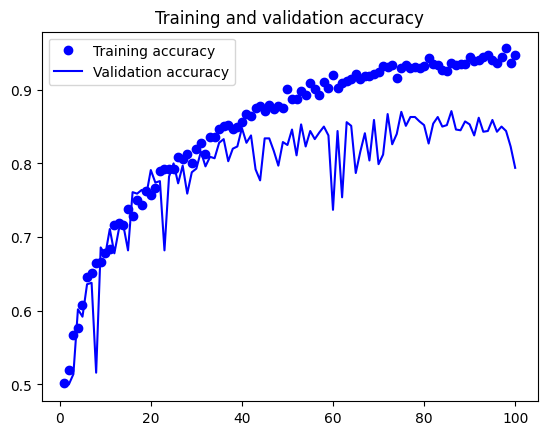

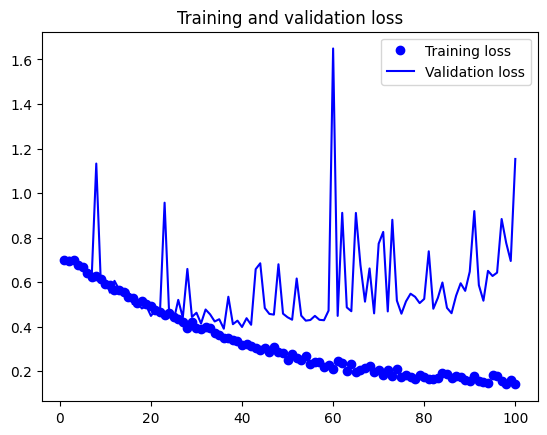

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## 성능 측정

In [ ]:
test_model = keras.models.load_model("dogs_vs_cats.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 3s 34ms/step - loss: 0.4662 - accuracy: 0.8395
테스트 정확도: 0.840


## 새로운 이미지 예측

정답 Target: tf.Tensor(1, shape=(), dtype=int32)
1/1 [==============================] - 0s 27ms/step
강아지일 확률: [0.9996259]


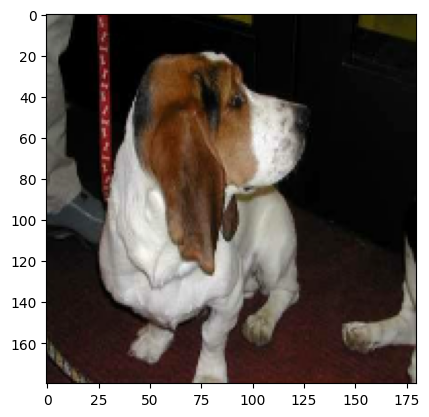

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img


for data_batch, labels_batch in test_dataset:
    plt.imshow(array_to_img(data_batch[0]))
    print("정답 Target:", labels_batch[0])   # 고양이 = 0, 강아지 = 1

    prediction = test_model.predict(data_batch)
    print("강아지일 확률:", prediction[0])   # 고양이 = 0, 강아지 = 1
    break